# 0.0. Entender o Problema

-- Objetivo do Problema: 
    -- 1.0. Previsão do primeiro destino que um novo usuário irá escolher.
    
    -- Porque?
        -- Qual o tipo de modelo de negócio do Airbnb?
            -- MarketPlace (Conecta pessoas que oferecem acomodação com pessias que estão procurando acomodação.)
            -- Oferta (Pessoas oferecendo acomodação)
                -- Métricas
                -- Tamanho do Portfólio
                -- Diversidade/Densidade de portfólio
                -- Preco Medio
                
            -- Demanda (Pessoas procurando acomodação)
                -- Número de Usuários
                -- LTV (Lifetime Value)
                -- CAC (Client Acquisition Cost)
                
                Gross Revenue = (Fee * Numero Clientes) - CAC
                
    
-- Proposta da Solução

    --- Modelo de Previsão do primeiro destino de um novo suário
    --- 1.0. Predicoes salvar em uma tabela em um banco de dados
    --- 2.0. API
            --- Input: usuario e suas caracteristicas
            --- output: usuario e suas caracteristicas com a **predição do destino**
            
    --- 16 ciclos

# <font color='red'> Ciclo01: End to End</font>

# 0.0. Imports

In [92]:
import pandas            as pd
import warnings
import matplotlib
import seaborn           as sns
import matplotlib.pyplot as plt 


from sklearn.model_selection import train_test_split
from IPython.core.display  import HTML
from scikitplot import metrics as  mt
from sklearn import preprocessing
from sklearn import metrics
from keras import models as ml
from keras import layers


## 0.1. Funções Auxiliares

In [30]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
    sns.set()
    pd.set_option('display.float_format', '{:.2f}'.format)
jupyter_settings()



warnings.filterwarnings('ignore')

## 0.2. Carregando Dados

In [2]:
# Granularidade: Usuário
df_raw = pd.read_csv('data/train_users_2.csv')
df_raw.shape

(213451, 16)

In [12]:
# # Granularidade: Ação
# df_sessions = pd.read_csv('data/sessions.csv')
# df_sessions.shape

(10567737, 6)

# 1.0. Descrição dos Dados

In [3]:
df1 = df_raw.copy()

In [4]:
print( f"Número de linhas: {df1.shape[0]} ")
print( f"Número de colunas: {df1.shape[1]} ")

Número de linhas: 213451 
Número de colunas: 16 


## 1.1. Tipo de Dados

In [5]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.2. Checando Valores Ausentes

In [6]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [7]:
# Removendo so dados ausentes completamente
df1 = df1.dropna()
df1.shape

(68171, 16)

## 1.3. Mudando Tipo de Dados

In [8]:
# date_account_created  
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( 'int64' )

## 1.4. Checando dados desbalanceados

In [9]:
df1.country_destination.value_counts( normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0. Filtragem dos Dados

In [10]:
df2 = df1.copy()

## 2.1. Filtrando Linhas

## 2.2. Selecionando colunas

# 3.0. Preparação dos dados

In [11]:
df3 = df2.copy()

In [62]:
# Variáveis Dummy
df3_dummy = pd.get_dummies( df3.drop(['id', 'country_destination'], axis=1) )

# Join Id e country_destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1)

# 4.0. Feature Selection

In [63]:
# Datas originais
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']

df4  = df3.drop( cols_drop, axis=1)

# 5.0. Modelo de Machine Learnign 
## Neural Network - Multi-Layer Perceptron

In [64]:
X = df4.drop( ['id', 'country_destination'], axis=1)
y = df4['country_destination'].copy()

In [65]:
# Divisão do dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=32)

In [66]:
ohe = preprocessing.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1,1) ).toarray()

In [67]:
# definição do modelo
model = ml.Sequential()
model.add( layers.Dense( 128, input_dim = X_train.shape[1], activation='relu' ) )
model.add( layers.Dense( 11, activation='softmax' ) )

# compilando o modelo
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# treinando o modelo
model.fit( X_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.3623 - accuracy: 0.7014
Epoch 2/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.2539 - accuracy: 0.7082
Epoch 3/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.2273 - accuracy: 0.7077
Epoch 4/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2080 - accuracy: 0.7083
Epoch 5/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1941 - accuracy: 0.7084
Epoch 6/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1770 - accuracy: 0.7085
Epoch 7/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1653 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1550 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1474 - accuracy: 0.7087
Epoch 10/100
1705/1705 [==============================] - 3s 2ms/step - l

1705/1705 [==============================] - 3s 2ms/step - loss: 1.1012 - accuracy: 0.7120
Epoch 80/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0998 - accuracy: 0.7120
Epoch 81/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1004 - accuracy: 0.7118
Epoch 82/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1003 - accuracy: 0.7119
Epoch 83/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1000 - accuracy: 0.7123
Epoch 84/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0998 - accuracy: 0.7121
Epoch 85/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0990 - accuracy: 0.7119
Epoch 86/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0991 - accuracy: 0.7122
Epoch 87/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0998 - accuracy: 0.7121
Epoch 88/100
1705/1705 [==============================] - 4s 2ms/step - loss:

# 6.0. Performace da NN

In [72]:
# predicao
pred_nn =  model.predict( X_test )

# inverter o One Hot Encoding
yhat_nn = ohe.inverse_transform( pred_nn )

# preparação para métricas
y_test_nn = y_test.to_numpy()
y_hat_nn=yhat_nn.reshape(1, -1) [0] 

427/427 [==============================] - 0s 983us/step


Acurácia: 70.31169783645032


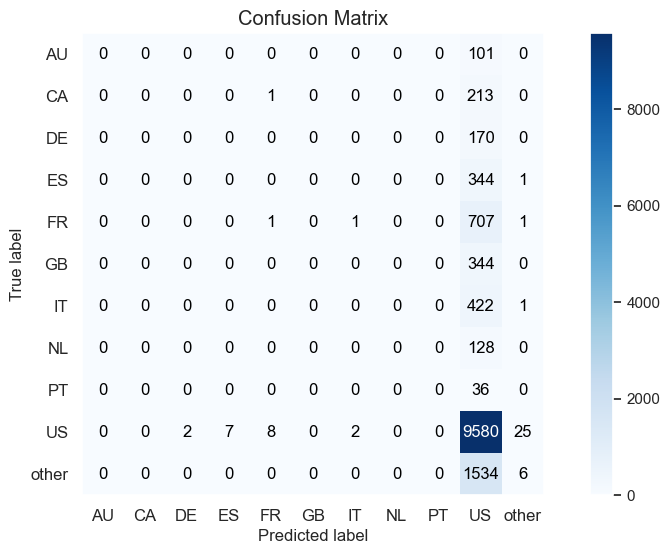

In [95]:
# Acurácia
acc_nn = metrics.accuracy_score( y_test_nn, y_hat_nn)
print( f"Acurácia: {acc_nn*100}" )

# Matriz de Confusão
mt.plot_confusion_matrix( y_test_nn, y_hat_nn, normalize=False);

# Balanced Acuracy
# F-Score Balanced
# Recall-Precision
# ROC
# Kappa Metrics
# Matthew Metrics